Using CPU : 14 threads
F=5 • Using shifted centre global_idx=0 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=30.0s


/state/partition1/job-65837189/ipykernel_788333/1461371418.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  1


→ Running panel: ALL


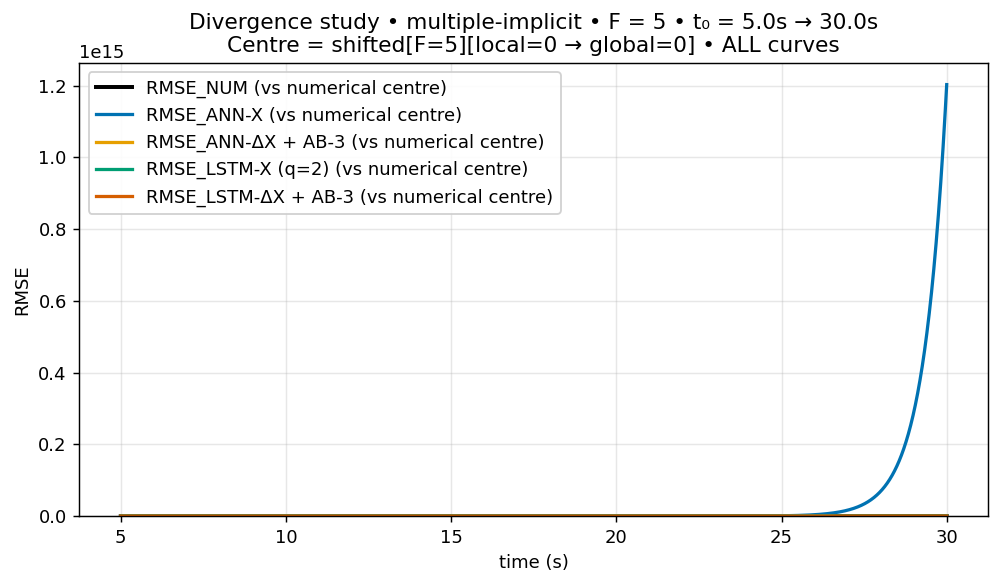


Final RMSE at t = T_END:
  NUM        : 2.6715e+00
  ANN-X      : 1.2030e+15
  ANN-ΔX     : 5.3490e+00
  LSTM-X     : 6.9072e+00  (q=2)
  LSTM-ΔX    : 3.1978e+00


In [1]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 5.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 30.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=5 • Using shifted centre global_idx=0 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=80.0s


/state/partition1/job-65837189/ipykernel_788333/836157696.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/j

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  2


→ Running panel: NO_ANNX


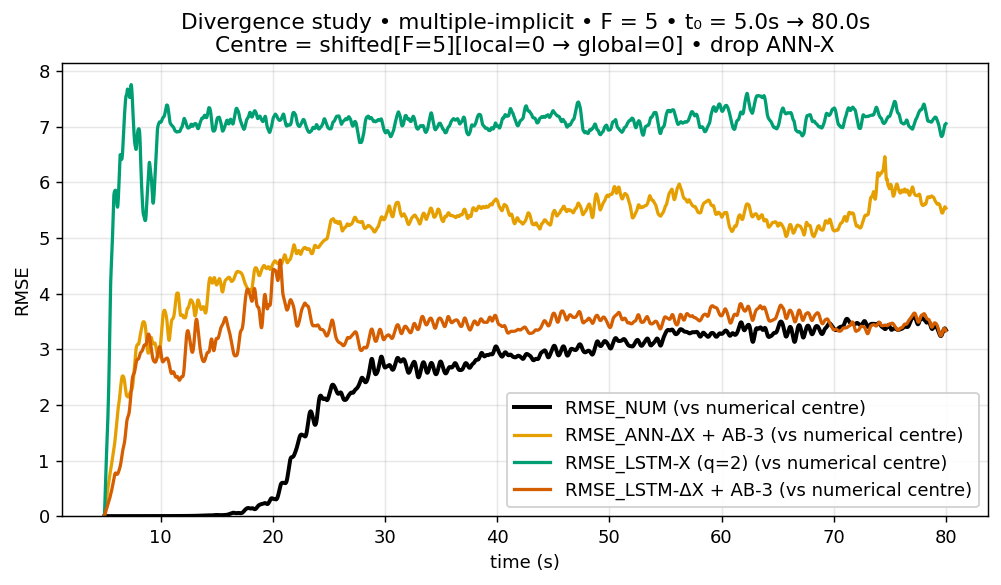


Final RMSE at t = T_END:
  NUM        : 3.3467e+00
  ANN-ΔX     : 5.5370e+00
  LSTM-X     : 7.0541e+00  (q=2)
  LSTM-ΔX    : 3.3333e+00


In [2]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 5.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 80.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=10 • Using shifted centre global_idx=1 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=30.0s


/state/partition1/job-65837189/ipykernel_788333/2926919240.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  1


→ Running panel: ALL


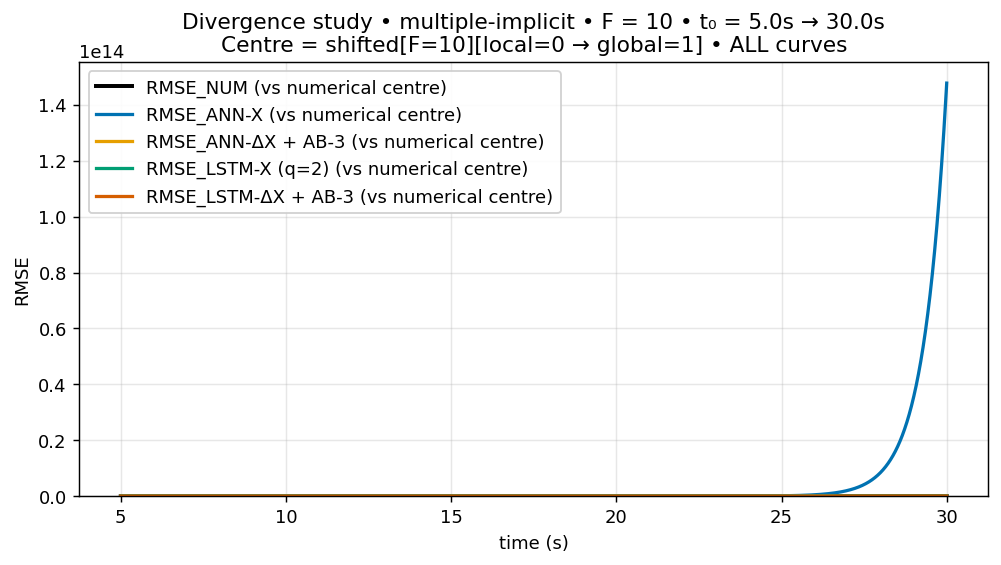


Final RMSE at t = T_END:
  NUM        : 5.9054e+00
  ANN-X      : 1.4778e+14
  ANN-ΔX     : 5.2231e+02
  LSTM-X     : 7.7902e+00  (q=2)
  LSTM-ΔX    : 5.0267e+00


In [3]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 10.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 30.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=10 • Using shifted centre global_idx=1 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=25.0s


/state/partition1/job-65837189/ipykernel_788333/3911651802.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  2


→ Running panel: NO_ANNX


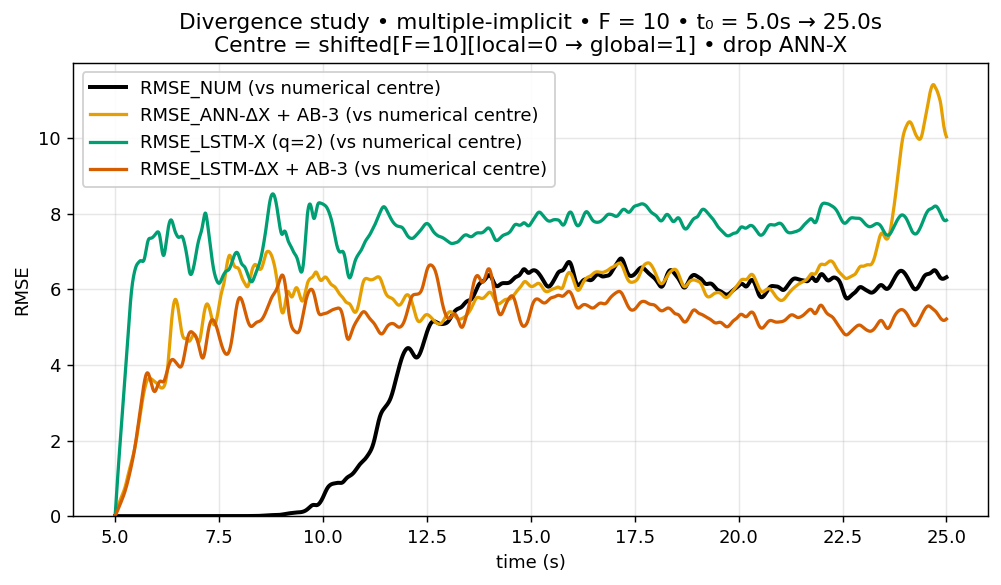


Final RMSE at t = T_END:
  NUM        : 6.3229e+00
  ANN-ΔX     : 1.0040e+01
  LSTM-X     : 7.8310e+00  (q=2)
  LSTM-ΔX    : 5.2172e+00


In [4]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 10.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 25.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=10 • Using shifted centre global_idx=1 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=80.0s


/state/partition1/job-65837189/ipykernel_788333/4008659885.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  3


→ Running panel: LSTMS_ONLY


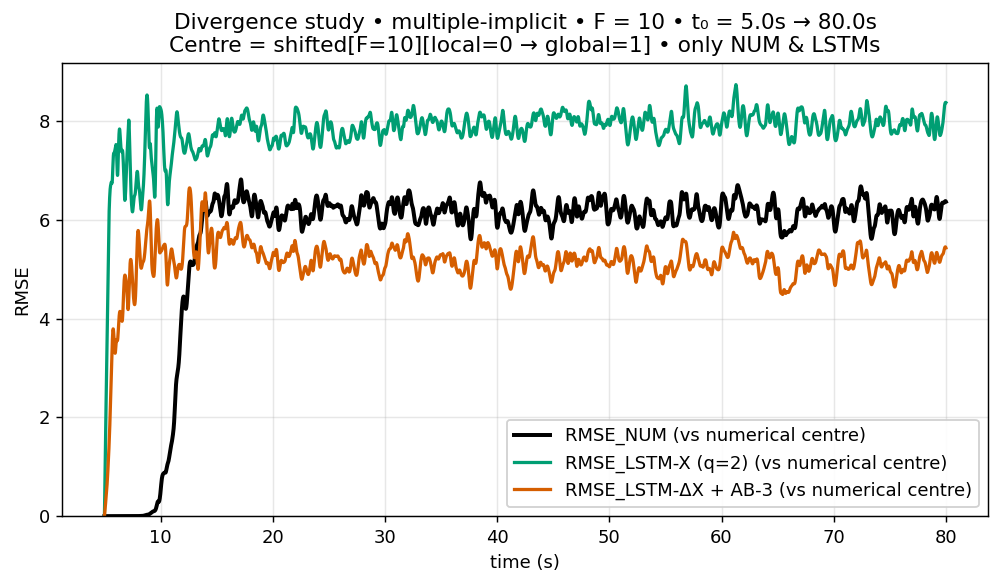


Final RMSE at t = T_END:
  NUM        : 6.3665e+00
  LSTM-X     : 8.3747e+00  (q=2)
  LSTM-ΔX    : 5.4317e+00


In [5]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 10.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 80.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=15 • Using shifted centre global_idx=2 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=30.0s


/state/partition1/job-65837189/ipykernel_788333/4050585187.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  1


→ Running panel: ALL


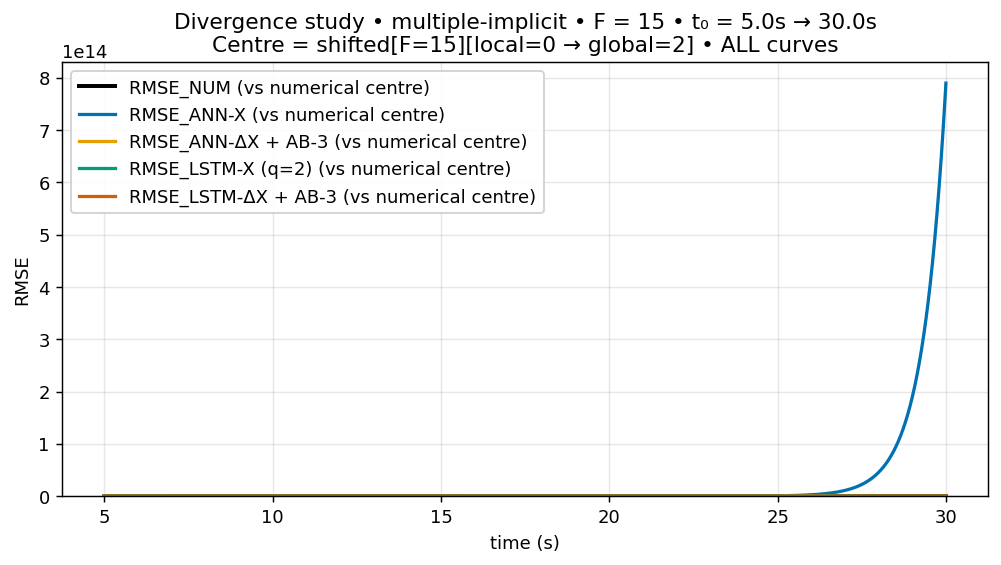


Final RMSE at t = T_END:
  NUM        : 9.0748e+00
  ANN-X      : 7.8995e+14
  ANN-ΔX     : 5.5733e+04
  LSTM-X     : 9.6575e+00  (q=2)
  LSTM-ΔX    : 7.2775e+00


In [6]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 15.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 30.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=15 • Using shifted centre global_idx=2 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=15.0s


/state/partition1/job-65837189/ipykernel_788333/3162084147.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  2


→ Running panel: NO_ANNX


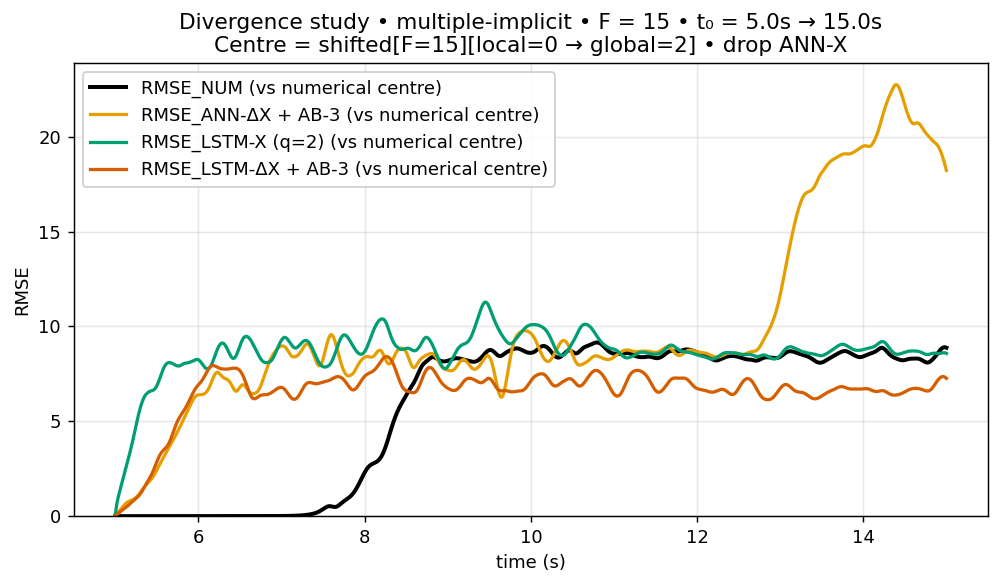


Final RMSE at t = T_END:
  NUM        : 8.8801e+00
  ANN-ΔX     : 1.8224e+01
  LSTM-X     : 8.5798e+00  (q=2)
  LSTM-ΔX    : 7.2669e+00


In [7]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 15.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 15.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")


Using CPU : 14 threads
F=15 • Using shifted centre global_idx=2 (local=0)
Ensemble: K=50, ε=1e-05, radius=1.29099e-05, t0=5.0s, T_END=80.0s


/state/partition1/job-65837189/ipykernel_788333/4274733261.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(path, map_location="cpu")
/state/partition1/

LSTM-X   : q=2, hidden=70
LSTM-ΔX  : window=1 (AB-3 in z)

Select panel to run:
  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)


Enter 1 / 2 / 3 (default=1):  3


→ Running panel: LSTMS_ONLY


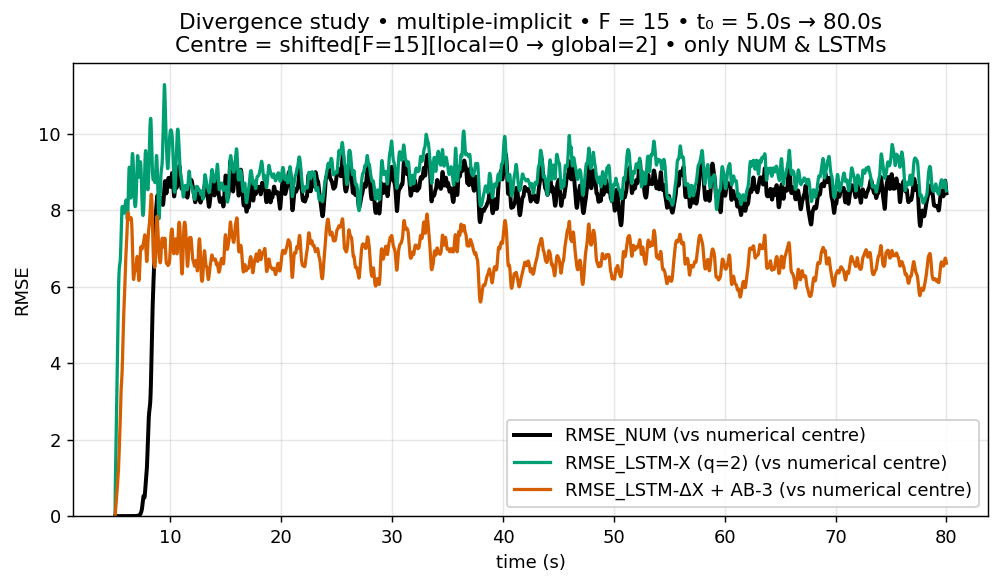


Final RMSE at t = T_END:
  NUM        : 8.4436e+00
  LSTM-X     : 8.5043e+00  (q=2)
  LSTM-ΔX    : 6.6168e+00


In [8]:
#!/usr/bin/env python3
# =============================================================================
#  "Old-style" divergence study • MULTIPLE-IMPLICIT (mixed-F)
#  -----------------------------------------------------------------------------
#  What this script does:
#    • Loads mixed-F shifted dataset + mixed-F checkpoints (ANN/LSTM).
#    • Lets you choose *one* forcing (5, 10, or 15) by editing a single variable.
#    • Lets you choose the horizon (T_END) by editing a single variable.
#    • Asks which panel to produce, then computes/plots ONLY that panel:
#        (1) 5 curves  : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)
#        (2) 4 curves  : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)      (drop ANN-X)
#        (3) 3 curves  : NUM,               LSTM-X,  LSTM-ΔX(+AB3)     (drop ANN-X & ANN-ΔX)
#
#  Notes:
#    • ΔX models are integrated with Euler→AB2→AB3 in z-space (normalised).
#    • LSTM-X uses a window seeded with centre-history (q-1 frames) + each ensemble member at t0.
#    • q for LSTM-X is read from ckpt metadata or parsed from filename with "_q{q}.pt".
#    • All methods share the same perturbation ensemble at t0 for fair comparison.
#    • Colors are FIXED per method so legends look consistent across panels.
# =============================================================================

import os, re, math, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ─────────────────────────────── EASY KNOBS ────────────────────────────────
FORCE_LABEL      = 15.0     # ← change to 5.0 / 10.0 / 15.0 to switch forcing (ONE place)
T_END            = 80.0     # ← change horizon here (ONE place)
TRAJ_LOCAL_INDEX = 0        # which F-subset trajectory to use as centre (0-based)

# Time/grid
DT, T0           = 0.005, 5.0

# Ensemble (shared by all methods)
K, EPS, SEED     = 50, 1e-5, 0
RADIUS           = EPS * math.sqrt(5.0/3.0)

# Data files (mixed-F)
SHIFTED_FILE     = "shifted_force5_10_15_data.npz"
TRAIN_FILE_MIXED = "force_5_10_15_data.npz"   # μ/σ fallback

# Multiple-implicit checkpoints
CKPT_ANN_X       = "standard_early_stopping_F5_10_15_annX.pt"                 # ANN-X (direct)
CKPT_ANN_dX      = "standard_early_stopping_F5_10_15_ann.pt"                  # ANN-ΔX (delta)
CKPT_LSTM_X      = "standard_early_stopping_force5_10_15_LSTM_H70_q2.pt"      # LSTM-X
CKPT_LSTM_dX     = "standard_early_stopping_force5_10_15_LSTM_dX_H70_q1.pt"   # LSTM-ΔX

# If the LSTM-X ckpt lacks 'lookback' and its filename has no _q{q}.pt, set an override (else leave None)
Q_OVERRIDE_LSTMX = None

# ───────────────────────────── Fixed method colors ─────────────────────────
# Okabe–Ito palette (colorblind-friendly)
COLORS = {
    "NUM":      "#000000",  # black
    "ANNX":     "#0072B2",  # blue
    "ANNDX":    "#E69F00",  # orange
    "LSTMX":    "#009E73",  # green
    "LSTMDX":   "#D55E00",  # vermillion
}
# ───────────────────────────────────────────────────────────────────────────

# ───────────────────────────── DEVICE / THREADS ────────────────────────────
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device("cuda:0")
    print(f"Using GPU : {torch.cuda.get_device_name(0)} (ID 0)")
else:
    DEVICE = torch.device("cpu")
    torch.set_num_threads(min(14, os.cpu_count() or 1))
    print(f"Using CPU : {torch.get_num_threads()} threads")
torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False, linewidth=120)

# ───────────────────────────── Utilities / Models ──────────────────────────
def l96_rhs(x, F=FORCE_LABEL):
    # x shape (..., 36)
    return (torch.roll(x, -1, -1) - torch.roll(x, 2, -1)) * torch.roll(x, 1, -1) - x + F

def rk4_step(x, dt=DT):
    k1 = l96_rhs(x); k2 = l96_rhs(x + 0.5*dt*k1)
    k3 = l96_rhs(x + 0.5*dt*k2); k4 = l96_rhs(x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0

def ab3_combine(dx1, dx_prev1, dx_prev2):
    if dx_prev1 is None:   return dx1
    if dx_prev2 is None:   return 1.5*dx1 - 0.5*dx_prev1
    return (23/12)*dx1 - (4/3)*dx_prev1 + (5/12)*dx_prev2

def _parse_q_from_filename(path: str):
    m = re.search(r"_q(\d+)\.pt$", os.path.basename(path))
    return int(m.group(1)) if m else None

def _find_state_dict(obj):
    if isinstance(obj, dict):
        if "net" in obj and isinstance(obj["net"], dict):
            return obj["net"]
        if len(obj) and all(isinstance(v, torch.Tensor) for v in obj.values()):
            return obj
        for v in obj.values():
            if isinstance(v, dict):
                sd = _find_state_dict(v)
                if sd is not None: return sd
    return None

def _infer_hidden_from_sd(sd: dict) -> int:
    key = "lstm.weight_hh_l0"
    if key in sd and sd[key].ndim == 2 and sd[key].shape[0] % 4 == 0:
        return sd[key].shape[1]
    for k, v in sd.items():
        if "weight_hh_l0" in k and isinstance(v, torch.Tensor) and v.ndim == 2 and v.shape[0] % 4 == 0:
            return v.shape[1]
    raise ValueError("Cannot infer hidden_size from LSTM state_dict.")

def make_mlp(sz=(36,128,128,64,36)):
    layers = []
    for i in range(len(sz)-1):
        layers.append(nn.Linear(sz[i], sz[i+1]))
        if i < len(sz)-2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class LSTMX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, q, n)
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

class LSTMdX(nn.Module):
    def __init__(self, hidden, n=36):
        super().__init__()
        self.lstm = nn.LSTM(n, hidden, batch_first=True)
        self.head = nn.Linear(hidden, n)
    def forward(self, w):  # (B, 1, n) in this study
        y,_ = self.lstm(w)
        return self.head(y[:, -1])

def load_ann_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = ck.get("net") if isinstance(ck, dict) and "net" in ck else ck
    net = make_mlp().to(DEVICE).eval()
    net.load_state_dict(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)
    return net, mu_t, sd_t

def load_lstm_x_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-X ckpt")

    # q detection
    q = None
    if isinstance(ck, dict):
        for k in ("lookback","q","q_len","window"):
            if k in ck and ck[k] is not None:
                try: q = int(ck[k]); break
                except: pass
    if q is None: q = _parse_q_from_filename(path)
    if q is None:
        if Q_OVERRIDE_LSTMX is None:
            raise ValueError("LSTM-X lookback not found. Set Q_OVERRIDE_LSTMX.")
        q = int(Q_OVERRIDE_LSTMX)

    # hidden
    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    # μ/σ
    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t, q, hidden

def load_lstm_dx_ckpt(path, train_fallback):
    ck = torch.load(path, map_location="cpu")
    sd = _find_state_dict(ck)
    if sd is None: raise RuntimeError("Could not find a state-dict in LSTM-ΔX ckpt")

    hidden = ck.get("hidden_size", None) if isinstance(ck, dict) else None
    if hidden is None: hidden = _infer_hidden_from_sd(sd)

    mu = ck.get("mean", None) if isinstance(ck, dict) else None
    sdv = ck.get("std",  None) if isinstance(ck, dict) else None
    if (mu is None) or (sdv is None):
        train = np.load(train_fallback)["X"].astype(np.float32).reshape(-1, 36)
        mu  = train.mean(0).astype(np.float32)
        sdv = (train.std(0) + 1e-8).astype(np.float32)
    mu_t = torch.from_numpy(np.asarray(mu,  dtype=np.float32)).to(DEVICE)
    sd_t = torch.from_numpy(np.asarray(sdv, dtype=np.float32)).to(DEVICE)

    net = LSTMdX(hidden).to(DEVICE).eval()
    net.load_state_dict(sd)
    return net, mu_t, sd_t

# ───────────────────────────── Load data & subset ─────────────────────────
shifted = np.load(SHIFTED_FILE)
X_all = shifted["X"].astype(np.float32)   # (traj, step, 36)
F_all = shifted["F"].astype(np.int32)     # (traj,)
_, N_STEPS, N = X_all.shape

steps_per_s = int(round(1/DT))
i0   = int(round(T0   * steps_per_s))
iend = int(round(T_END * steps_per_s))
if iend <= i0:
    raise ValueError("T_END must be > T0")
T_steps = iend - i0
t_axis  = T0 + np.arange(T_steps + 1, dtype=np.float32) * DT

# Filter to the chosen forcing and select centre trajectory locally
F_int = int(FORCE_LABEL)
idx_f = np.where(F_all == F_int)[0]
assert len(idx_f) > 0, f"No shifted trajectories found for F={F_int}"
X_F = X_all[idx_f]
assert 0 <= TRAJ_LOCAL_INDEX < len(X_F), f"TRAJ_LOCAL_INDEX out of range (0..{len(X_F)-1})"
global_centre_idx = int(idx_f[TRAJ_LOCAL_INDEX])
centre_traj = X_F[TRAJ_LOCAL_INDEX]
x0_centre  = centre_traj[i0].copy()

# ──────────────────────── Shared perturbation ensemble ────────────────────
rng  = np.random.default_rng(SEED)
pert = RADIUS * rng.standard_normal((K, N)).astype(np.float32)
W0   = np.vstack([x0_centre[None], x0_centre[None] + pert]).astype(np.float32)  # (B,36)
B    = K + 1

print(f"F={F_int} • Using shifted centre global_idx={global_centre_idx} (local={TRAJ_LOCAL_INDEX})")
print(f"Ensemble: K={K}, ε={EPS:g}, radius={RADIUS:g}, t0={T0:.1f}s, T_END={T_END:.1f}s")

# ────────────────────────────── Load models/μσ ────────────────────────────
ann_x,   mu_annx,  sd_annx   = load_ann_ckpt   (CKPT_ANN_X,  TRAIN_FILE_MIXED)   # ANN-X (direct)
ann_dx,  mu_anndx, sd_anndx  = load_ann_ckpt   (CKPT_ANN_dX, TRAIN_FILE_MIXED)   # ANN-ΔX (delta)
lstm_x,  mu_lx,    sd_lx, q_lx, Hx = load_lstm_x_ckpt(CKPT_LSTM_X,  TRAIN_FILE_MIXED)
lstm_dx, mu_ldx,   sd_ldx   = load_lstm_dx_ckpt(CKPT_LSTM_dX, TRAIN_FILE_MIXED)

print(f"LSTM-X   : q={q_lx}, hidden={Hx}")
print( "LSTM-ΔX  : window=1 (AB-3 in z)")

# ───────────────────────────── Panel selection ────────────────────────────
print("\nSelect panel to run:")
print("  1) ALL          : NUM, ANN-X, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  2) NO_ANNX      : NUM, ANN-ΔX(+AB3), LSTM-X, LSTM-ΔX(+AB3)")
print("  3) LSTMS_ONLY   : NUM, LSTM-X, LSTM-ΔX(+AB3)")
panel_choice = input("Enter 1 / 2 / 3 (default=1): ").strip()
if panel_choice not in {"1","2","3",""}:
    print("Unrecognised choice; defaulting to 1 (ALL).")
    panel_choice = "1"
if panel_choice == "": panel_choice = "1"

PANEL = { "1":"ALL", "2":"NO_ANNX", "3":"LSTMS_ONLY" }[panel_choice]
print(f"→ Running panel: {PANEL}")

run_num   = True
run_annx  = (PANEL == "ALL")
run_anndx = (PANEL in ("ALL", "NO_ANNX"))
run_lx    = True
run_ldx   = True

# ────────────────── Initialise method states at t0 (z-space) ──────────────
num_state = torch.from_numpy(W0).to(DEVICE)                         # (B,36)

if run_annx:
    annx_norm  = (num_state - mu_annx) / sd_annx                    # (B,36)
if run_anndx:
    anndx_norm = (num_state - mu_anndx) / sd_anndx                  # (B,36)
if run_ldx:
    lstdx_norm = (num_state - mu_ldx) / sd_ldx                      # (B,36)

# LSTM-X window seeding: (q-1) frames from centre history + each member at t0
if run_lx:
    if q_lx > 1:
        hist_phys = torch.from_numpy(centre_traj[i0 - q_lx + 1 : i0]).to(DEVICE).float()  # (q-1,36)
        if hist_phys.shape[0] != q_lx - 1:
            raise RuntimeError("Not enough history before t0 for requested q_lx.")
        win_lx = torch.empty((B, q_lx, N), device=DEVICE, dtype=torch.float32)
        win_lx[:, :q_lx-1, :] = hist_phys.unsqueeze(0).expand(B, q_lx-1, N)
        win_lx[:,  q_lx-1, :] = num_state
        win_lx = (win_lx - mu_lx) / sd_lx
    else:
        win_lx = ((num_state - mu_lx) / sd_lx).unsqueeze(1)         # (B,1,36)

# AB-3 memories (only for ΔX methods that run)
dx1_prev_ann  = dx2_prev_ann  = None if run_anndx else None
dx1_prev_lstm = dx2_prev_lstm = None if run_ldx   else None

# ─────────────────────────── Allocate RMSE buffers ────────────────────────
rmse_num  = np.empty(T_steps + 1, dtype=np.float64)
rmse_ax   = np.empty(T_steps + 1, dtype=np.float64) if run_annx  else None
rmse_adx  = np.empty(T_steps + 1, dtype=np.float64) if run_anndx else None
rmse_lx   = np.empty(T_steps + 1, dtype=np.float64) if run_lx    else None
rmse_ldx  = np.empty(T_steps + 1, dtype=np.float64) if run_ldx   else None

def rmse_vs_centre(phys_state: torch.Tensor, base_centre: torch.Tensor) -> float:
    # phys_state: (B,36); base_centre: (36,)
    diffs = phys_state[1:] - base_centre.unsqueeze(0)        # (K,36)
    return float(torch.sqrt((diffs**2).mean()).item())

# ───────────────────────────── Time marching ──────────────────────────────
for s in range(T_steps + 1):
    base_num = num_state[0]  # numerical centre at this time

    # ---- compute RMSEs at current time s ----
    rmse_num[s] = rmse_vs_centre(num_state, base_num)

    if run_annx:
        annx_phys  = annx_norm  * sd_annx  + mu_annx
        rmse_ax[s] = rmse_vs_centre(annx_phys, base_num)

    if run_anndx:
        anndx_phys = anndx_norm * sd_anndx + mu_anndx
        rmse_adx[s]= rmse_vs_centre(anndx_phys, base_num)

    if run_lx:
        lx_phys    = win_lx[:, -1, :] * sd_lx + mu_lx
        rmse_lx[s] = rmse_vs_centre(lx_phys, base_num)

    if run_ldx:
        lstdx_phys = lstdx_norm * sd_ldx + mu_ldx
        rmse_ldx[s]= rmse_vs_centre(lstdx_phys, base_num)

    # ---- advance one step (except after final sample) ----
    if s == T_steps: break

    # Numerical
    num_state = rk4_step(num_state)

    with torch.no_grad():
        if run_annx:
            annx_norm = ann_x(annx_norm)                     # ANN-X (direct next-state in z)

        if run_anndx:
            dx1_ann = ann_dx(anndx_norm)                     # ANN-ΔX (+AB-3 in z)
            step_ann = ab3_combine(dx1_ann, dx1_prev_ann, dx2_prev_ann)
            anndx_norm = anndx_norm + step_ann
            dx2_prev_ann, dx1_prev_ann = dx1_prev_ann, dx1_ann

        if run_lx:
            y_lx = lstm_x(win_lx)                            # LSTM-X (direct next-state in z)
            if win_lx.shape[1] > 1:
                win_lx = torch.cat([win_lx[:, 1:, :], y_lx.unsqueeze(1)], dim=1)
            else:
                win_lx[:, 0, :] = y_lx

        if run_ldx:
            dx1_lstm = lstm_dx(lstdx_norm.unsqueeze(1))      # LSTM-ΔX (+AB-3 in z) with window=1
            step_lstm = ab3_combine(dx1_lstm, dx1_prev_lstm, dx2_prev_lstm)
            lstdx_norm = lstdx_norm + step_lstm
            dx2_prev_lstm, dx1_prev_lstm = dx1_prev_lstm, dx1_lstm

# ─────────────────────────────── Plot panel ───────────────────────────────
plt.figure(figsize=(7.8, 4.6), dpi=130)

# Always plot NUM first (fixed color)
plt.plot(t_axis, rmse_num,  lw=2.2, color=COLORS["NUM"],    label="RMSE_NUM (vs numerical centre)")

if PANEL == "ALL":
    plt.plot(t_axis, rmse_ax,   lw=1.8, color=COLORS["ANNX"],   label="RMSE_ANN-X (vs numerical centre)")
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "ALL curves"
elif PANEL == "NO_ANNX":
    plt.plot(t_axis, rmse_adx,  lw=1.8, color=COLORS["ANNDX"],  label="RMSE_ANN-ΔX + AB-3 (vs numerical centre)")
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "drop ANN-X"
else:  # LSTMS_ONLY
    plt.plot(t_axis, rmse_lx,   lw=1.8, color=COLORS["LSTMX"],  label=f"RMSE_LSTM-X (q={q_lx}) (vs numerical centre)")
    plt.plot(t_axis, rmse_ldx,  lw=1.8, color=COLORS["LSTMDX"], label="RMSE_LSTM-ΔX + AB-3 (vs numerical centre)")
    title_suffix = "only NUM & LSTMs"

plt.title(f"Divergence study • multiple-implicit • F = {F_int} • t₀ = {T0:.1f}s → {T_END:.1f}s\n"
          f"Centre = shifted[F={F_int}][local={TRAJ_LOCAL_INDEX} → global={global_centre_idx}] • {title_suffix}")
plt.xlabel("time (s)"); plt.ylabel("RMSE")
plt.ylim(0); plt.grid(alpha=0.3); plt.legend(framealpha=0.9)
plt.tight_layout(); plt.show()

# ──────────────────────────── Print final RMSEs ───────────────────────────
print("\nFinal RMSE at t = T_END:")
print(f"  NUM        : {rmse_num[-1]:.4e}")
if PANEL == "ALL":
    print(f"  ANN-X      : {rmse_ax [-1]:.4e}")
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
elif PANEL == "NO_ANNX":
    print(f"  ANN-ΔX     : {rmse_adx[-1]:.4e}")
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
else:  # LSTMS_ONLY
    print(f"  LSTM-X     : {rmse_lx [-1]:.4e}  (q={q_lx})")
    print(f"  LSTM-ΔX    : {rmse_ldx[-1]:.4e}")
